# Read All Dataset CSV

In [8]:
import os
import csv
import pandas as pd
import numpy as np

In [9]:
from sklearn.preprocessing import LabelEncoder

dataset_names=[]
X_trains=[]
y_trains=[]
X_tests=[]
for folder_name in os.listdir("./Competition_data"):
    # print(folder_name)
    
    x_train = pd.read_csv(f"./Competition_data/{folder_name}/X_train.csv",header=0)
    y_train = pd.read_csv(f"./Competition_data/{folder_name}/y_train.csv",header=0)
    x_test = pd.read_csv(f"./Competition_data/{folder_name}/X_test.csv",header=0)  
    
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()
    categorical_columns = x_train.columns[7:20]
    # Apply LabelEncoder to each categorical column
    X_train_encoded = x_train.copy()
    X_test_encoded = x_test.copy()
    for col in categorical_columns:
        # Fit the label encoder on the combined data of train and test to avoid unseen labels
        combined_data = pd.concat([x_train[col], x_test[col]], axis=0)
        label_encoder.fit(combined_data)

        X_train_encoded[col] = label_encoder.transform(x_train[col])
        X_test_encoded[col] = label_encoder.transform(x_test[col])

    dataset_names.append(folder_name)
    X_trains.append(X_train_encoded)
    y_trains.append(y_train)
    X_tests.append(X_test_encoded)

        

In [16]:
X_trains[1]

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11
0,-0.867096,-0.058159,-0.680074,-0.579243,-0.998596,0.357914,-0.922364,1,0,0,1
1,-0.867096,-0.440925,0.292599,-0.311655,-1.340803,-0.821160,-0.500339,2,0,1,1
2,2.041433,2.126488,-0.959850,1.189920,0.615931,-0.821160,0.144572,0,0,0,1
3,-0.867096,-0.908566,0.861105,0.228543,-1.600750,-0.821160,-0.553887,6,0,0,1
4,-0.867096,-0.639831,0.786109,0.618892,0.795106,-0.821160,0.873483,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
462,-0.867096,-0.440925,0.468499,0.006619,-0.765175,-0.821160,-0.098624,1,0,0,0
463,-0.867096,-1.820848,0.921883,-1.073206,0.529563,-0.821160,-1.242851,0,0,1,1
464,-0.867096,-0.081967,-0.680074,-0.579243,-0.998596,0.357914,-0.708281,1,0,0,1
465,0.232561,0.024997,0.921883,-0.400438,-0.484287,0.727911,-0.154460,4,1,1,1


## Data Preprocessing & Feature Engineering

In [3]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [4]:
for i in range(len(dataset_names)):
    # Initialize the model
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Initialize RFECV
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='roc_auc')

    X_train_encoded = X_trains[i]
    y_train = y_trains[i]

    # Fit RFECV
    rfecv.fit(X_train_encoded, y_train.values.ravel())

    # Get the selected features
    selected_features = X_train_encoded.columns[rfecv.support_]

    print("Selected features:", selected_features)

    # Transform the datasets
    X_trains[i] = X_train_encoded[selected_features]
    X_tests[i] = X_test_encoded[selected_features]

Selected features: Index(['Feature_1'], dtype='object')
Selected features: Index(['Feature_2', 'Feature_4', 'Feature_5', 'Feature_7'], dtype='object')
Selected features: Index(['Feature_2', 'Feature_4', 'Feature_43', 'Feature_60', 'Feature_61'], dtype='object')


KeyError: "['Feature_60', 'Feature_61'] not in index"

## train test split & build Model
You can select an appropriate model and perform corresponding hyperparameter tuning.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score
import xgboost as xgb
from sklearn.svm import SVC

使用VotingClassifier

In [ ]:
from sklearn.ensemble import VotingClassifier

y_predicts_voting = []
for i in range(len(dataset_names)):
    X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train_selected[i], y_trains[i], test_size=0.2, random_state=42)
    
    # 準備基模型
    base_models = [
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
        ('xgb', xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
    ]

    # 初始化Voting Classifier
    voting_model = VotingClassifier(estimators=base_models, voting='soft')

    # 訓練Voting Classifier
    voting_model.fit(X_train_part, y_train_part)

    # 使用驗證集進行預測
    y_pred = voting_model.predict(X_valid)
    y_pred_proba = voting_model.predict_proba(X_valid)[:, 1]

    # 評估模型
    accuracy = accuracy_score(y_valid, y_pred)
    auc = roc_auc_score(y_valid, y_pred_proba)

    print(f"{i} times finish")
    print(f"AUC: {auc:.2f}")

    # 使用訓練好的Voting模型來預測X_test並儲存結果
    y_test_pred = voting_model.predict_proba(X_tests[i])[:, 1]
    df = pd.DataFrame(y_test_pred, columns=['y_predict_proba'])
    y_predicts_voting.append(df)

KeyError: 0

In [ ]:
for idx,dataset_name in enumerate(dataset_names):
    df=y_predicts_voting[idx]
    df.to_csv(f'./Competition_data/{dataset_name}/y_predict.csv', index=False,header=True)

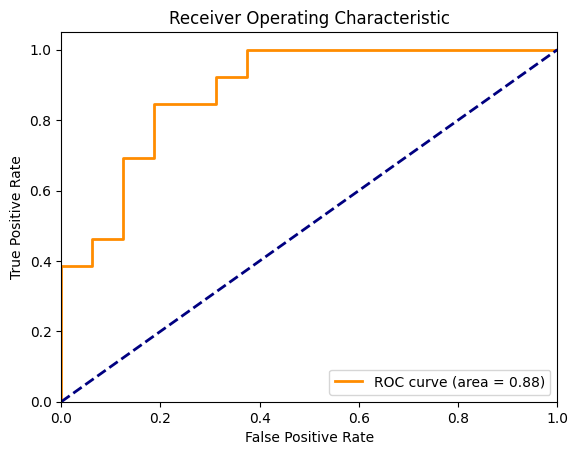

In [ ]:
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Assuming y_valid and y_pred_proba are defined
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

使用stack處理

In [ ]:
y_predicts=[]
for i in range(len(dataset_names)):
    X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_trains[i], y_trains[i], test_size=0.2, random_state=42)
    
    # 準備基模型
    base_models = [  
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
        ('xgb', xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
    ]

    # 準備次級模型
    meta_model = LogisticRegression()

    # 初始化Stacking Classifier
    stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=10)

    # 訓練Stacking Classifier
    stacking_model.fit(X_train_part, y_train_part)

    # 使用驗證集進行預測
    y_pred = stacking_model.predict(X_valid)
    y_pred_proba = stacking_model.predict_proba(X_valid)[:, 1] 

    # 評估模型
    accuracy = accuracy_score(y_valid, y_pred)
    # f1 = f1_score(y_valid, y_pred, average='weighted')
    # precision = precision_score(y_valid, y_pred, average='weighted')

    # print(f"Accuracy: {accuracy:.2f}")
    # print(f"F1 Score: {f1:.2f}")
    # print(f"Precision: {precision:.2f}")
    print(f"{i}times finish")
    print(f"AUC: {accuracy:.2f}")

    # 使用訓練好的Stacking模型來預測X_test並儲存結果
    y_test_pred = stacking_model.predict_proba(X_tests[i])[:, 1] 
    df = pd.DataFrame(y_test_pred, columns=['y_predict_proba'])
    y_predicts.append(df)


## Save result

In [ ]:
for idx,dataset_name in enumerate(dataset_names):
    df=y_predicts[idx]
    df.to_csv(f'./Competition_data/{dataset_name}/y_predict.csv', index=False,header=True)

NameError: name 'y_predicts' is not defined